In [330]:
from __future__ import annotations

from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from typing import Union
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [331]:
from __future__ import annotations

from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from typing import Union

import numpy as np

NumT = Union[np.ndarray, float]

@dataclass
class MixtureDist(ABC):
    pi: NumT
    K: int = field(init=False)

    def __post_init__(self):
        self.K = len(self.pi)

    @abstractmethod
    def sample(self, L: int) -> NumT:
        raise NotImplementedError

    @abstractmethod
    def p_xz(self, x: NumT, k: int) -> NumT:
        raise NotImplementedError

    def p_x(self, x: NumT) -> NumT:
        return np.sum([self.pi[k] * self.p_xz(x, k) for k in range(self.K)], axis=0)

@dataclass
class GMDist(MixtureDist):
    mu: NumT
    sigma2: NumT

    @classmethod
    def random(cls, K: int) -> GMDist:
        mu = np.random.normal(size=K).astype(np.float32)
        sigma2 = np.exp(np.random.normal(size=K) - 1).astype(np.float32)
        pi = np.random.dirichlet(5 * np.ones(K)).astype(np.float32)

        return cls(pi, mu, sigma2)

    def sample(self, L: int) -> NumT:
        choices = np.random.choice(np.arange(self.K), size=L, p=self.pi)
        sample = np.random.normal(self.mu[choices], np.sqrt(self.sigma2[choices])).astype(np.float32)

        return sample

    @staticmethod
    def normal_pdf(x: NumT, mu: NumT, sigma2: NumT) -> NumT:
        return np.exp(-0.5 * (x - mu) ** 2 / sigma2) / np.sqrt(2 * np.pi * sigma2)

    def p_xz(self, x: NumT, k: int) -> NumT:
        return self.normal_pdf(x, self.mu[k], self.sigma2[k])

@dataclass
class UMDist(MixtureDist):
    a: NumT
    b: NumT

    @classmethod
    def random(cls, K: int) -> UMDist:
        a = np.random.uniform(-1, 3, size=K).astype(np.float32)
        b = np.random.uniform(3, 5, size=K).astype(np.float32)
        pi = np.random.dirichlet(5 * np.ones(K)).astype(np.float32)

        return cls(pi, a, b)

    def sample(self, L: int) -> NumT:
        choices = np.random.choice(np.arange(self.K), size=L, p=self.pi)
        sample = np.random.uniform(self.a[choices], self.b[choices]).astype(np.float32)

        return sample

    @staticmethod
    def uniform_pdf(x: NumT, a: NumT, b: NumT) -> NumT:
        return (x >= a) * (x <= b) / (b - a)

    def p_xz(self, x: NumT, k: int) -> NumT:
        return self.uniform_pdf(x, self.a[k], self.b[k])

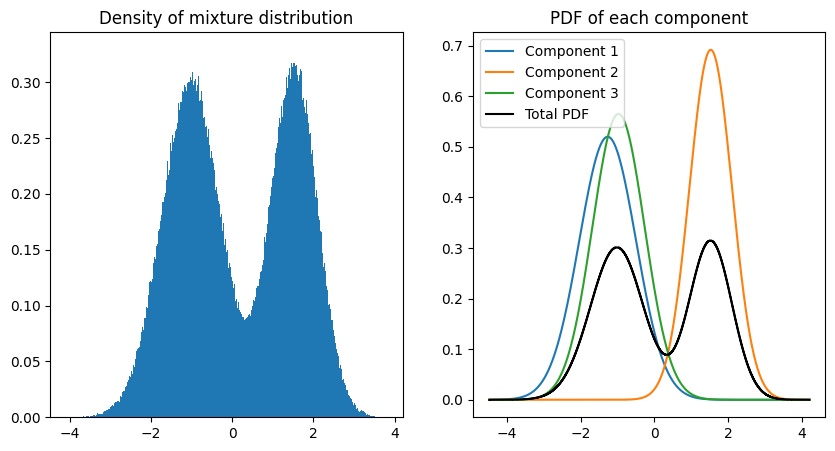

In [332]:
np.random.seed(30)
K = 3
L = 1_000_000
dist = GMDist.random(K)
data = dist.sample(L)
linsp = np.linspace(data.min(), data.max(), 1000)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(data, bins=1000, density=True)
axs[0].set_xlim(data.min(), data.max())
axs[0].set_title("Density of mixture distribution")

for i in range(K):
    component = dist.p_xz(linsp, i)
    # component = dist.pi[i] * dist.p_xz(linsp, i)
    axs[1].plot(linsp, component, label=f"Component {i + 1}")

total_pdf = dist.p_x(linsp)
axs[1].plot(linsp, total_pdf, label="Total PDF", drawstyle="steps", color="black")
axs[1].legend()
axs[1].set_title("PDF of each component")
plt.show()

In [333]:
class GMModel(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.K = K
        self.mu = nn.Parameter(torch.randn(K))
        self.logsigma2 = nn.Parameter(torch.randn(K))
        self.logpi = nn.Parameter(torch.zeros(K))

    @property
    def pi(self):
        return torch.softmax(self.logpi, dim=0)

    @property
    def sigma2(self):
        return torch.exp(self.logsigma2)

    def p_z(self):
        return torch.logsumexp(self.logpi, dim=0) - self.logpi

    def neglog_normal_pdf(self, x):
        return 0.5 * (torch.log(torch.tensor([2 * torch.pi])) + self.logsigma2 + (x - self.mu)**2 / self.sigma2)

    def loss(self, x):
        return -torch.logsumexp(-(self.neglog_normal_pdf(x) + self.p_z()), dim=1).mean()

    def p_xz(self, x, k):
        return torch.exp(-self.neglog_normal_pdf(x))[:, k]

    def p_x(self, x):
        return torch.exp(-self.neglog_normal_pdf(x)) @ self.pi

In [334]:
torch.manual_seed(0)
model = GMModel(K)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [335]:
data_t = torch.from_numpy(data).reshape(-1, 1)
batch_size = 2000
epochs = 1000
for i in range(epochs):
    data_t_mb = data_t[torch.randperm(len(data_t))[:batch_size]]
    optimizer.zero_grad()
    loss = model.loss(data_t_mb)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.item()}")

Epoch 0, Loss: 1.9672168493270874
Epoch 100, Loss: 1.6446197032928467
Epoch 200, Loss: 1.6156870126724243
Epoch 300, Loss: 1.6080695390701294
Epoch 400, Loss: 1.5944157838821411
Epoch 500, Loss: 1.627582311630249
Epoch 600, Loss: 1.633905053138733
Epoch 700, Loss: 1.594885230064392
Epoch 800, Loss: 1.603471279144287
Epoch 900, Loss: 1.6057617664337158


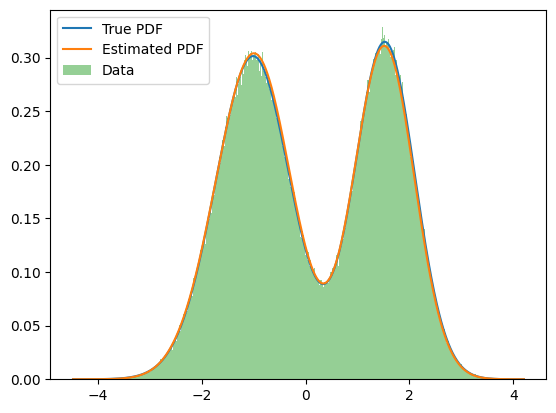

In [336]:
linsp_t = torch.from_numpy(linsp.astype(np.float32)).reshape(-1, 1)
with torch.no_grad():
    plt.plot(linsp, dist.p_x(linsp), label="True PDF")
    plt.plot(linsp, model.p_x(linsp_t).numpy(), label="Estimated PDF")
    plt.hist(data, bins=1000, density=True, alpha=0.5, label="Data")
    plt.legend()
    plt.show()

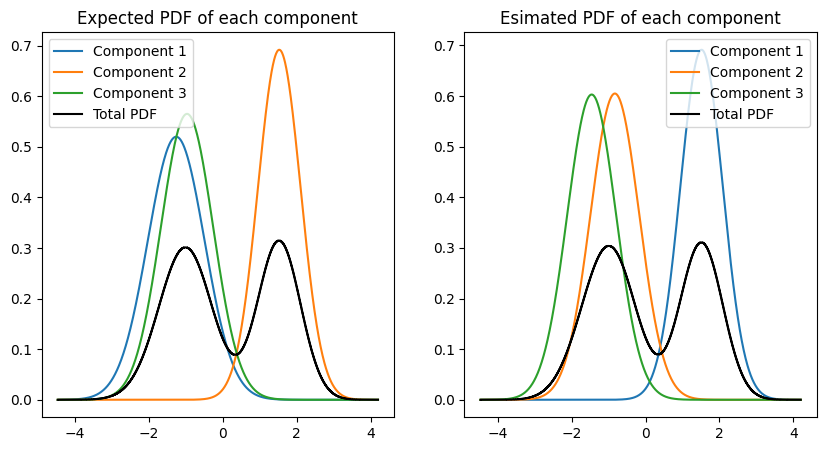

In [337]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(K):
    component = dist.p_xz(linsp, i)
    axs[0].plot(linsp, component, label=f"Component {i + 1}")

total_pdf = dist.p_x(linsp)
axs[0].plot(linsp, total_pdf, label="Total PDF", drawstyle="steps", color="black")
axs[0].legend()
axs[0].set_title("Expected PDF of each component")

with torch.no_grad():
    for i in range(K):
        component = model.p_xz(linsp_t, i).numpy()
        axs[1].plot(linsp, component, label=f"Component {i + 1}")

    total_pdf = model.p_x(linsp_t).numpy()
    axs[1].plot(linsp, total_pdf, label="Total PDF", drawstyle="steps", color="black")
    axs[1].legend()
    axs[1].set_title("Esimated PDF of each component")
    plt.show()

<ipython-input-338-6a6bb96a73ab>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


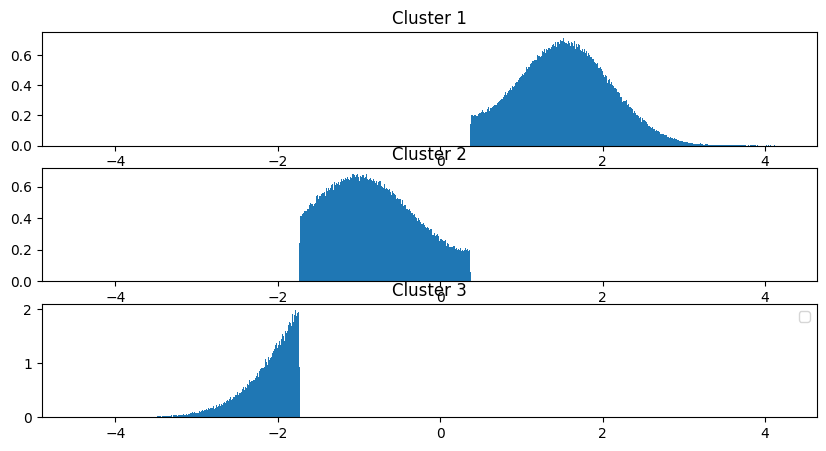

In [338]:
_, bins = np.histogram(data, bins=1001)
with torch.no_grad():
    probs = []
    for i in range(K):
        probs.append((model.p_xz(data_t, i) * model.pi[i]))

    preds = torch.argmax(torch.stack(probs), dim=0).numpy()

fig, axs = plt.subplots(K, figsize=(10, 5))
for k in range(K):
    axs[k].hist(data[preds == k], bins=bins, density=True)
    axs[k].set_title(f"Cluster {k + 1}")
plt.legend()
plt.show()

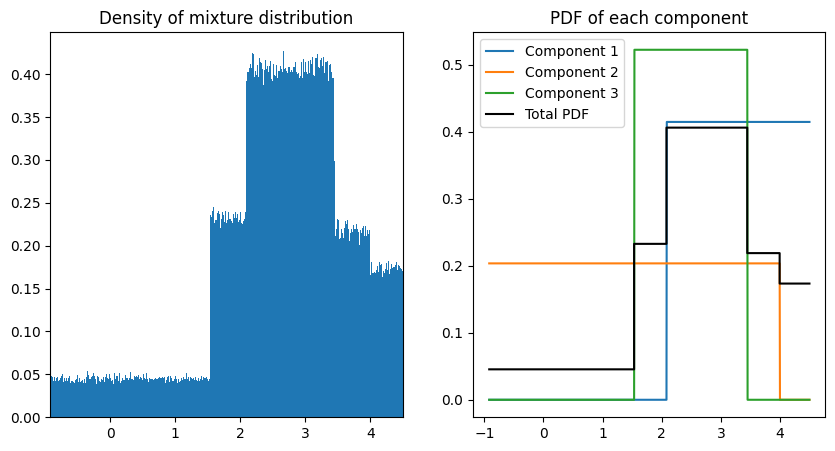

In [339]:
np.random.seed(10)
K = 3
L = 1_000_000
dist = UMDist.random(K)
data = dist.sample(L)
linsp = np.linspace(data.min(), data.max(), 1000)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(data, bins=1000, density=True)
axs[0].set_xlim(data.min(), data.max())
axs[0].set_title("Density of mixture distribution")

for i in range(K):
    component = dist.p_xz(linsp, i)
    # component = dist.pi[i] * dist.p_xz(linsp, i)
    axs[1].plot(linsp, component, label=f"Component {i + 1}")

total_pdf = dist.p_x(linsp)
axs[1].plot(linsp, total_pdf, label="Total PDF", drawstyle="steps", color="black")
axs[1].legend()
axs[1].set_title("PDF of each component")
plt.show()

In [340]:
K_ = 8
torch.manual_seed(0)
model = GMModel(K_)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [341]:
data_t = torch.from_numpy(data).reshape(-1, 1)
batch_size = 2000
epochs = 1000
for i in range(epochs):
    data_t_mb = data_t[torch.randperm(len(data_t))[:batch_size]]
    optimizer.zero_grad()
    loss = model.loss(data_t_mb)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.item()}")

Epoch 0, Loss: 3.645949363708496
Epoch 100, Loss: 1.8310908079147339
Epoch 200, Loss: 1.4972771406173706
Epoch 300, Loss: 1.4247902631759644
Epoch 400, Loss: 1.3945016860961914
Epoch 500, Loss: 1.4374459981918335
Epoch 600, Loss: 1.414933443069458
Epoch 700, Loss: 1.4203097820281982
Epoch 800, Loss: 1.4189096689224243
Epoch 900, Loss: 1.4238262176513672


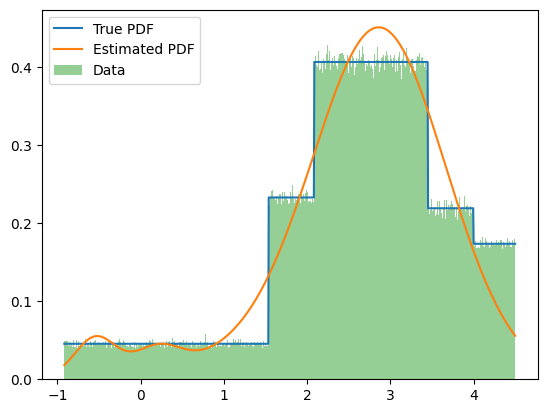

In [342]:
linsp_t = torch.from_numpy(linsp.astype(np.float32)).reshape(-1, 1)
with torch.no_grad():
    plt.plot(linsp, dist.p_x(linsp), label="True PDF")
    plt.plot(linsp, model.p_x(linsp_t).numpy(), label="Estimated PDF")
    plt.hist(data, bins=1000, density=True, alpha=0.5, label="Data")
    plt.legend()
    plt.show()

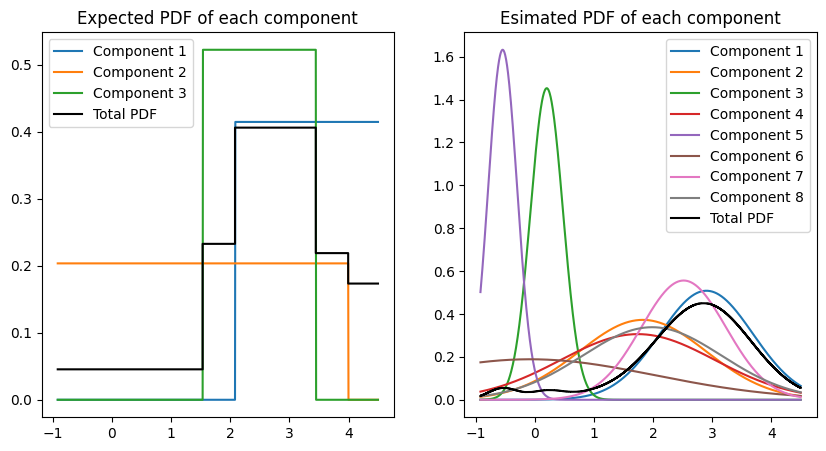

In [343]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(K):
    component = dist.p_xz(linsp, i)
    axs[0].plot(linsp, component, label=f"Component {i + 1}")

total_pdf = dist.p_x(linsp)
axs[0].plot(linsp, total_pdf, label="Total PDF", drawstyle="steps", color="black")
axs[0].legend()
axs[0].set_title("Expected PDF of each component")

with torch.no_grad():
    for i in range(K_):
        component = model.p_xz(linsp_t, i).numpy()
        axs[1].plot(linsp, component, label=f"Component {i + 1}")

    total_pdf = model.p_x(linsp_t).numpy()
    axs[1].plot(linsp, total_pdf, label="Total PDF", drawstyle="steps", color="black")
    axs[1].legend()
    axs[1].set_title("Esimated PDF of each component")
    plt.show()

## Probabilistic Regression

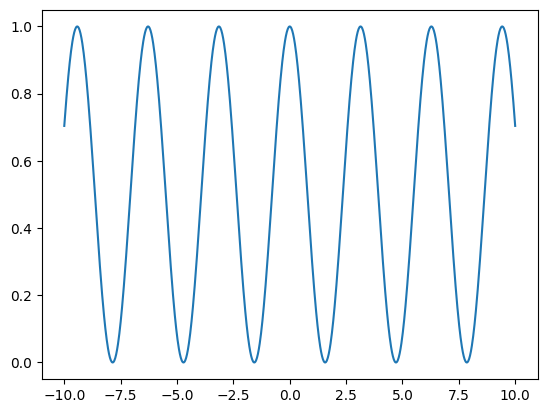

In [344]:
x = np.linspace(-10, 10, 1000)
plt.plot(x, np.cos(x)**2)

In [407]:
def mean_y(x):
    return 1 / (1 + np.exp(-x))

def sigma2_y(x):
    return 0.6 * np.cos(x)**2 + 0.01 # Cannot be 0

def gen_data(L):
    x = np.random.normal(0, 1, L)
    y = np.random.normal(mean_y(x), np.sqrt(sigma2_y(x)))
    return x, y

np.random.seed(100)
L = 1000
x, y = gen_data(L)

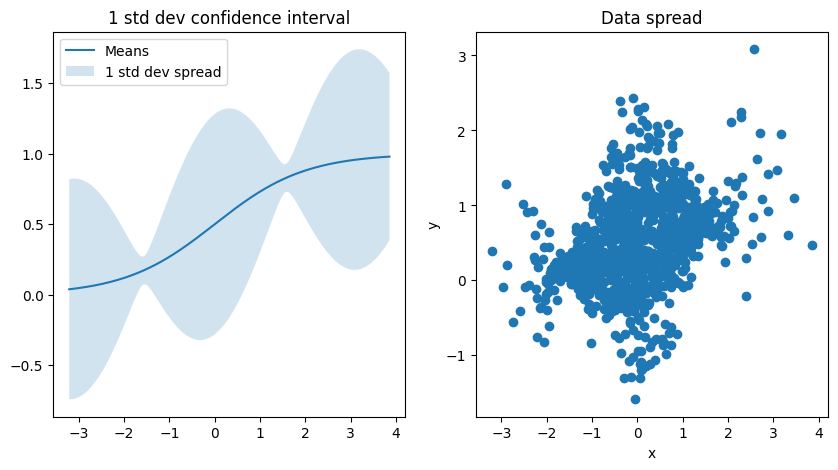

In [408]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
linsp = np.linspace(x.min(), x.max(), 1000)
stddev = np.sqrt(sigma2_y(linsp))
axs[0].plot(linsp, mean_y(linsp), label="Means")
axs[0].fill_between(linsp, mean_y(linsp) - stddev, mean_y(linsp) + stddev, alpha=0.2, label="1 std dev spread")
axs[0].legend()
axs[0].set_title("1 std dev confidence interval")

axs[1].scatter(x, y)
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("Data spread")
plt.show()

In [409]:
class PRModel(nn.Module):
    def __init__(self, hidden_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.net(x)

In [410]:
torch.manual_seed(0)
pr_model = PRModel(100)
optimizer = optim.Adam(pr_model.parameters(), lr=1e-3)

In [411]:
for i in range(2000):
    x_, y_ = gen_data(L)
    x_t = torch.from_numpy(x_.astype(np.float32)).reshape(-1, 1)
    y_t = torch.from_numpy(y_.astype(np.float32)).reshape(-1)
    mu, logvar = pr_model(x_t).t()
    # loss = 0.5 * (logvar + (y_t - mu)**2 / torch.exp(logvar)).mean()
    loss = 0.5 * (torch.tensor(2 * torch.pi).log() + logvar + (y_t - mu)**2 / torch.exp(logvar)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.item()}")

Epoch 0, Loss: 1.2350271940231323
Epoch 100, Loss: 0.7837170362472534
Epoch 200, Loss: 0.7869136333465576
Epoch 300, Loss: 0.7011582255363464
Epoch 400, Loss: 0.7008205652236938
Epoch 500, Loss: 0.7259478569030762
Epoch 600, Loss: 0.6956921219825745
Epoch 700, Loss: 0.6886675953865051
Epoch 800, Loss: 0.6988793611526489
Epoch 900, Loss: 0.6898019909858704
Epoch 1000, Loss: 0.7258703708648682
Epoch 1100, Loss: 0.703535795211792
Epoch 1200, Loss: 0.7300911545753479
Epoch 1300, Loss: 0.6966155767440796
Epoch 1400, Loss: 0.6476414799690247
Epoch 1500, Loss: 0.7330783605575562
Epoch 1600, Loss: 0.6980021595954895
Epoch 1700, Loss: 0.7047208547592163
Epoch 1800, Loss: 0.7424823045730591
Epoch 1900, Loss: 0.7171254754066467


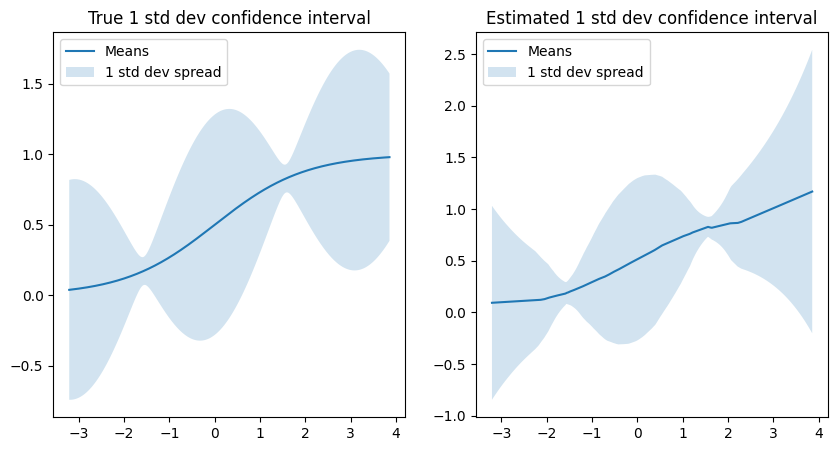

In [412]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
linsp = np.linspace(x.min(), x.max(), 1000)
stddev = np.sqrt(sigma2_y(linsp))
axs[0].plot(linsp, mean_y(linsp), label="Means")
axs[0].fill_between(linsp, mean_y(linsp) - stddev, mean_y(linsp) + stddev, alpha=0.2, label="1 std dev spread")
axs[0].legend()
axs[0].set_title("True 1 std dev confidence interval")

linsp_t = torch.from_numpy(linsp.astype(np.float32)).reshape(-1, 1)
with torch.no_grad():
    mu, logvar = pr_model(linsp_t).t()
    stddev = torch.exp(0.5 * logvar)
    axs[1].plot(linsp, mu.numpy(), label="Means")
    axs[1].fill_between(linsp, (mu - stddev).numpy(), (mu + stddev).numpy(), alpha=0.2, label="1 std dev spread")
    axs[1].legend()
    axs[1].set_title("Estimated 1 std dev confidence interval")

plt.show()

In [413]:
class PRModel(nn.Module):
    def __init__(self, hidden_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

In [414]:
torch.manual_seed(0)
pr_model = PRModel(100)
optimizer = optim.Adam(pr_model.parameters(), lr=1e-3)

In [415]:
for i in range(2000):
    x_, y_ = gen_data(L)
    x_t = torch.from_numpy(x_.astype(np.float32)).reshape(-1, 1)
    y_t = torch.from_numpy(y_.astype(np.float32)).reshape(-1)
    yhat = pr_model(x_t).reshape(-1)
    loss = ((y_t - yhat)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.item()}")

Epoch 0, Loss: 0.7483572959899902
Epoch 100, Loss: 0.33367079496383667
Epoch 200, Loss: 0.3612394630908966
Epoch 300, Loss: 0.3381257951259613
Epoch 400, Loss: 0.352970689535141
Epoch 500, Loss: 0.31690576672554016
Epoch 600, Loss: 0.34753867983818054
Epoch 700, Loss: 0.36881953477859497
Epoch 800, Loss: 0.35183313488960266
Epoch 900, Loss: 0.3641740381717682
Epoch 1000, Loss: 0.33554837107658386
Epoch 1100, Loss: 0.3368220031261444
Epoch 1200, Loss: 0.33275464177131653
Epoch 1300, Loss: 0.34330031275749207
Epoch 1400, Loss: 0.33027610182762146
Epoch 1500, Loss: 0.3583884835243225
Epoch 1600, Loss: 0.34305888414382935
Epoch 1700, Loss: 0.3592228293418884
Epoch 1800, Loss: 0.3317212462425232
Epoch 1900, Loss: 0.3671514391899109


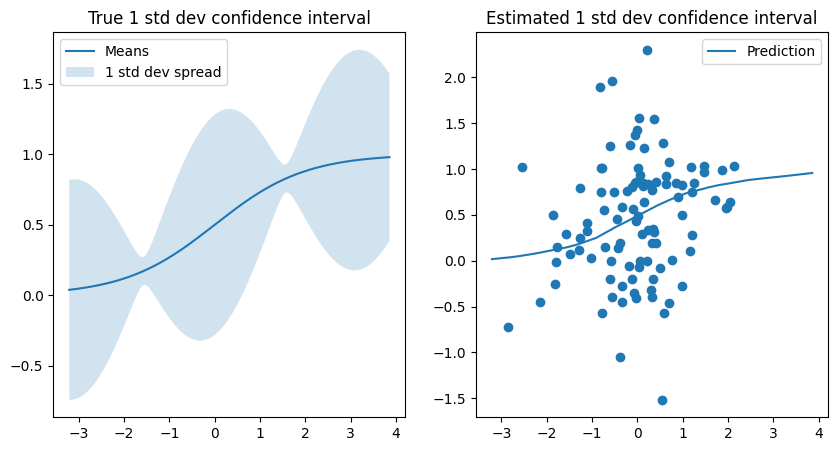

In [416]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
linsp = np.linspace(x.min(), x.max(), 1000)
stddev = np.sqrt(sigma2_y(linsp))
axs[0].plot(linsp, mean_y(linsp), label="Means")
axs[0].fill_between(linsp, mean_y(linsp) - stddev, mean_y(linsp) + stddev, alpha=0.2, label="1 std dev spread")
axs[0].legend()
axs[0].set_title("True 1 std dev confidence interval")

linsp_t = torch.from_numpy(linsp.astype(np.float32)).reshape(-1, 1)
with torch.no_grad():
    axs[1].plot(linsp, pr_model(linsp_t).reshape(-1), label="Prediction")
    x, y = gen_data(100)
    axs[1].scatter(x, y)
    axs[1].legend()
    axs[1].set_title("Estimated 1 std dev confidence interval")

plt.show()

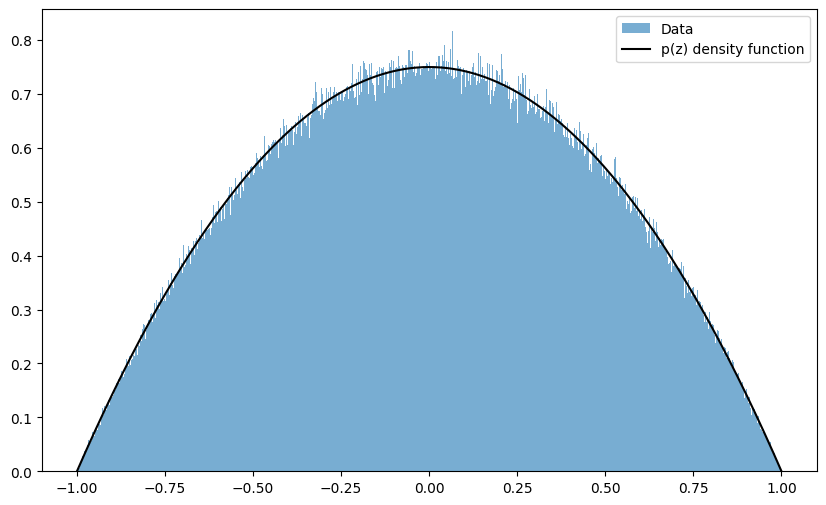

In [423]:
def P_inv(epsilon):
    return 2 * np.cos((np.arccos(1 - 2 * epsilon) + np.pi) / 3)

def p_z(z):
    return 3 / 4 * (1 - z**2) * (np.abs(z) <= 1)

epsilon = np.random.uniform(0, 1, 1_000_000)
z = P_inv(epsilon)

plt.figure(figsize=(10, 6))
plt.hist(z, bins=1000, density=True, alpha=0.6, label="Data")
linsp = np.linspace(-1, 1, 1000)
plt.plot(linsp, p_z(linsp), color="black", label="p(z) density function")
plt.legend()
plt.show()